In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# **1. EDA**

In [ ]:
# --- 1. Konfiguration ---

# Gesamtanzahl der benötigten Proben
N_SAMPLES = 699 

# Definierte Spalten
SPALTEN = [
    "id",
    "clump_thickness",
    "size_uniformity",
    "shape_uniformity",
    "marginal_adhesion",
    "epithelial_size",
    "bare_nucleoli",
    "bland_chromatin",
    "normal_nucleoli",
    "mitoses",
    "class"
]

# Für reproduzierbare Ergebnisse
SEED = 42
np.random.seed(SEED) 

# --- 2. Synthetische Daten generieren (699 Zeilen, 11 Spalten) ---

print(f"Generiere Haupt-Dataset mit {N_SAMPLES} Zeilen.")

# Generiere numerische Merkmale (Spalten 1 bis 9: Werte 1-10)
numerische_merkmale = np.random.randint(1, 11, size=(N_SAMPLES, 9))

# Generiere die Zielvariable 'class' (Spalte 10: Werte 0 oder 1)
ziel_klasse = np.random.randint(0, 2, size=N_SAMPLES).reshape(-1, 1)

# Generiere die ID-Spalte (Spalte 0)
ids = np.arange(100, 100 + N_SAMPLES).reshape(-1, 1)

# Kombiniere alle Spalten
roh_daten = np.hstack((ids, numerische_merkmale, ziel_klasse))

# Erstelle den Pandas DataFrame
df_gesamt = pd.DataFrame(roh_daten, columns=SPALTEN)
# Stellen Sie sicher, dass alle außer 'class' int sind, 'class' wird später zu float/NaN
df_gesamt.iloc[:, -1] = df_gesamt.iloc[:, -1].astype(int)
df_gesamt.iloc[:, -1] = df_gesamt.iloc[:, -1].astype('category')

# --- 3. Aufteilung in Train (559), Test (70), Aim (70) ---

# Schritt A: Aim-Set (70 Zeilen) abtrennen
aim_size = 70 / N_SAMPLES
df_temp, df_aim = train_test_split(
    df_gesamt,
    test_size=aim_size,
    random_state=SEED,
    stratify=df_gesamt['class'] 
)

# Schritt B: Den Rest (df_temp) in Train und Test aufteilen
test_size_temp = 70 / len(df_temp)
df_train, df_test = train_test_split(
    df_temp,
    test_size=test_size_temp,
    random_state=SEED,
    stratify=df_temp['class']
)

# --- 4. Bereinigung der 'class'-Spalte im Aim-Dataset ---

print("\nLeere die 'class'-Spalte im Aim-Dataset...")

# Setze alle Werte in der 'class'-Spalte des Aim-Datasets auf NaN
df_aim['class'] = np.nan

In [ ]:
# number of rows and columns

print("Train", df_train.shape)
print("Test", df_test.shape)
print("Aim", df_aim.shape)

Train (559, 11)
Test (70, 11)
Aim (70, 11)


In [ ]:
# check data types and convert to correct format

df_aim.loc[:, 'class'] = df_aim.loc[:, 'class'].astype('category')
display(print(df_train.info()))
display(print(df_test.info()))
display(print(df_aim.info()))

In [ ]:
# check for unique values of classes in train- and test set (aim_set does not contain classes)

print(df_train['class'].unique())
print(df_test['class'].unique())

[1, 0]
Categories (2, int64): [0, 1]
[0, 1]
Categories (2, int64): [0, 1]


In [ ]:
# check distribituon of classes in train- and test dataset 
print("Train\n", df_train.loc[:, 'class'].value_counts(normalize=True))
print("Test\n", df_test.loc[:, 'class'].value_counts(normalize=True))

Train
 class
1    0.511628
0    0.488372
Name: proportion, dtype: float64
Test
 class
1    0.514286
0    0.485714
Name: proportion, dtype: float64


In [ ]:
# check for missing values and handle them

print("Train\n\n", df_train.isna().sum())
print("Test\n\n", df_test.isna().sum())
print("Aim\n\n", df_aim.isna().sum())

Train

 id                   0
clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64
Test

 id                   0
clump_thickness      0
size_uniformity      0
shape_uniformity     0
marginal_adhesion    0
epithelial_size      0
bare_nucleoli        0
bland_chromatin      0
normal_nucleoli      0
mitoses              0
class                0
dtype: int64
Aim

 id                    0
clump_thickness       0
size_uniformity       0
shape_uniformity      0
marginal_adhesion     0
epithelial_size       0
bare_nucleoli         0
bland_chromatin       0
normal_nucleoli       0
mitoses               0
class                70
dtype: int64


# **2. Data preparation, modeling and model interpretation**

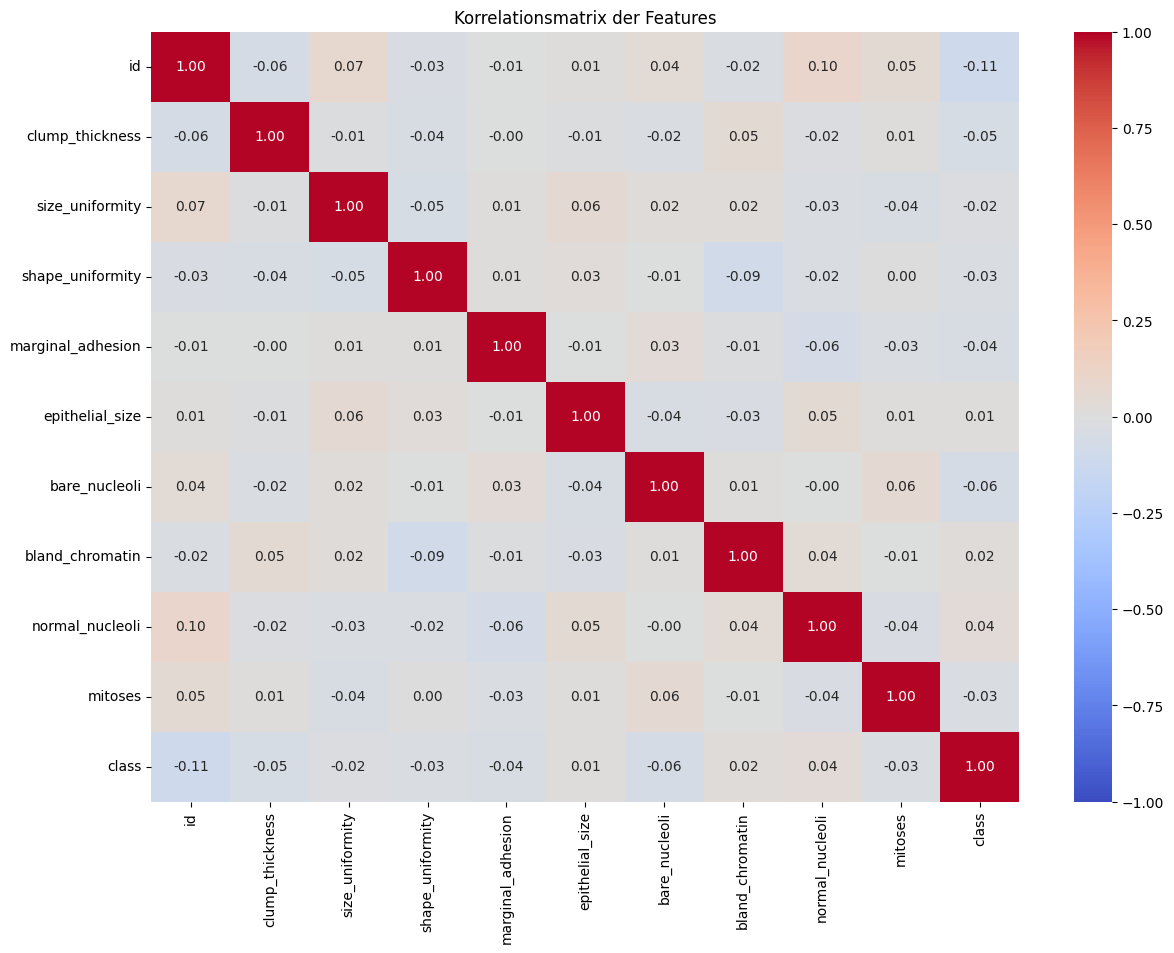

In [ ]:
# check for intercorrelations in train set
df_train.corr()

# Zuerst die Korrelationsmatrix berechnen
correlation_matrix = df_train.corr()

# Plot-Größe festlegen
plt.figure(figsize=(14, 10))

# Heatmap erstellen
sns.heatmap(
    correlation_matrix,
    annot=True,     # Koeffizienten anzeigen
    fmt='.2f',      # Format auf zwei Dezimalstellen
    vmin=-1,        # Farbskala-Minimum
    vmax=1,         # Farbskala-Maximum
    cmap='coolwarm' # Eine Farbskala, die positiv/negativ gut unterscheidet
)

# Titel und Anzeige
plt.title('Korrelationsmatrix der Features')
plt.show()

In [ ]:
# feature matrix and target vector for train set
from sklearn.preprocessing import StandardScaler

features_train = df_train.loc[:, ['bland_chromatin', 'mitoses']]
target_train = df_train.loc[:, 'class']
scaler = StandardScaler()
features_train_standardized = scaler.fit_transform(features_train)

In [ ]:
# feature matrix and target vector for test set
features_test = df_test.loc[:, ['bland_chromatin', 'mitoses']]
target_test = df_test.loc[:, 'class']
features_test_standardized = scaler.transform(features_test)

# **3. Ermittlung eines passenden 𝑘 für die Anzahl der nächsten Nachbarn für Klassifikation**

In [ ]:
# model evaluation with accuracy for k=1 to k=10
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 1. Leere Liste für die Genauigkeitswerte erstellen
score_list = []

# 2. Schleife durch die Anzahl der Nachbarn von 1 bis 10
for k in range(1, 11):
    # a) Modell mit dem aktuellen k-Wert instanziieren
    model_knn = KNeighborsClassifier(n_neighbors=k)
    
    # b) Modell auf die standardisierten Trainingsdaten anpassen (Fitting)
    model_knn.fit(features_train_standardized, target_train)
    
    # c) Vorhersagen auf dem standardisierten Testdatensatz tätigen
    target_test_pred = model_knn.predict(features_test_standardized)
    
    # d) Genauigkeit (Accuracy) berechnen
    accuracy = accuracy_score(target_test, target_test_pred)
    
    # e) Genauigkeitswert zur Liste hinzufügen
    score_list.append(accuracy)

# Ergebnis ausgeben
print("Genauigkeitswerte (Accuracy Scores) für k=1 bis k=10:")
for k, score in enumerate(score_list, 1):
    print(f"k = {k}: {score:.4f}")

print("\nDie Liste mit allen Genauigkeitswerten:")
print(score_list)

Genauigkeitswerte (Accuracy Scores) für k=1 bis k=10:
k = 1: 0.4714
k = 2: 0.4571
k = 3: 0.4857
k = 4: 0.4429
k = 5: 0.4571
k = 6: 0.4286
k = 7: 0.4714
k = 8: 0.4571
k = 9: 0.4429
k = 10: 0.4714

Die Liste mit allen Genauigkeitswerten:
[0.4714285714285714, 0.45714285714285713, 0.4857142857142857, 0.44285714285714284, 0.45714285714285713, 0.42857142857142855, 0.4714285714285714, 0.45714285714285713, 0.44285714285714284, 0.4714285714285714]


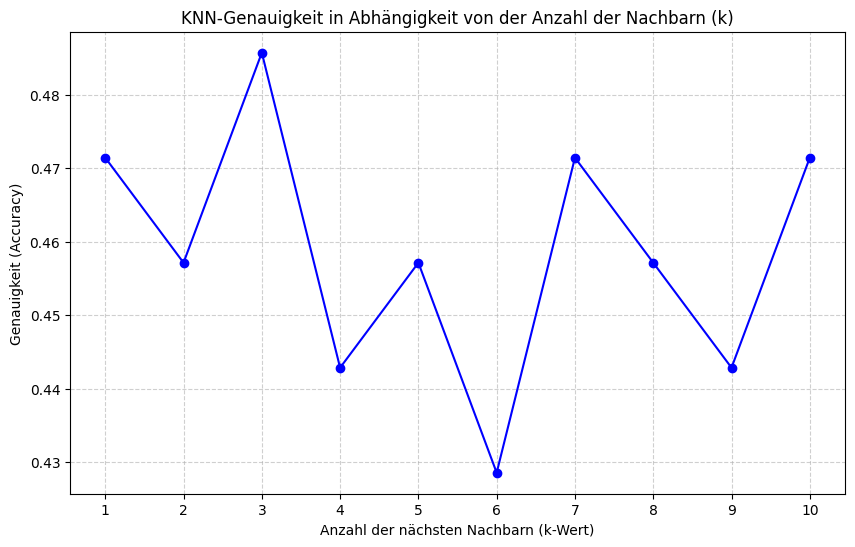

In [ ]:
# plot accuracy scores
# Plot der Genauigkeitswerte für jeden k-Wert

# 1. Plot-Größe festlegen
plt.figure(figsize=(10, 6))

# 2. Daten plotten
# x-Achse: Zahlenreihe von 1 bis 10 (range(1, 11))
# y-Achse: Die berechneten Genauigkeitswerte (score_list)
plt.plot(range(1, 11), score_list, marker='o', linestyle='-', color='blue')

# 3. Beschriftungen und Titel hinzufügen
plt.title('KNN-Genauigkeit in Abhängigkeit von der Anzahl der Nachbarn (k)')
plt.xlabel('Anzahl der nächsten Nachbarn (k-Wert)')
plt.ylabel('Genauigkeit (Accuracy)')

# 4. Gitternetzlinien hinzufügen und Achsen anpassen
plt.xticks(range(1, 11)) # Stellt sicher, dass nur ganzzahlige k-Werte angezeigt werden
plt.grid(True, linestyle='--', alpha=0.6)

# 5. Graph anzeigen
plt.show()

In [ ]:
# choose k with best accuracy among k=1 and k=10 and plot confusion matrix for test dataset
from sklearn.metrics import confusion_matrix

# 1. Modell mit dem optimalen k-Wert (k=4) instanziieren
model_knn = KNeighborsClassifier(n_neighbors=3)

# 2. Modell an die standardisierten Trainingsdaten anpassen (Fitting)
model_knn.fit(features_train_standardized, target_train)

# 3. Vorhersagen auf dem standardisierten Testdatensatz tätigen
target_test_pred = model_knn.predict(features_test_standardized)

# 4. Wahrheitsmatrix (Confusion Matrix) erstellen
# confusion_matrix(tatsächliche Werte, vorhergesagte Werte)
conf_matrix = confusion_matrix(target_test, target_test_pred)

# Ergebnis ausgeben
print("K-Nearest-Neighbors Modell mit k=4 ist trainiert.")
print("\nDie Wahrheitsmatrix (Confusion Matrix) für das Testdatenset:")
print(conf_matrix)

K-Nearest-Neighbors Modell mit k=4 ist trainiert.

Die Wahrheitsmatrix (Confusion Matrix) für das Testdatenset:
[[14 20]
 [16 20]]


# **4. Klassifikation der Krebszellenproben als gut- bzw. bösartig**

In [ ]:
# feature matrix and prediction of target vector for df_aim 

# 1. Feature-Matrix für das Zieldatenset erstellen
features_aim = df_aim[['bland_chromatin', 'mitoses']]

# 2. Features des Zieldatensets mit dem TRAINIERTEN Scaler standardisieren
# Wichtig: Nur .transform() verwenden, NICHT .fit_transform() oder .fit()
features_aim_standardized = scaler.transform(features_aim)

# 3. Vorhersagen mit dem trainierten KNN-Modell (k=4) tätigen
target_aim_pred = model_knn.predict(features_aim_standardized)

# 4. Vorhersagen als neue Spalte an df_aim anhängen
df_aim['class_pred'] = target_aim_pred

# 5. Die ersten 5 Zeilen von df_aim ausgeben
print("Die ersten 5 Zeilen von df_aim mit der neuen Vorhersagespalte 'class_pred':\n")
df_aim.head()

Die ersten 5 Zeilen von df_aim mit der neuen Vorhersagespalte 'class_pred':



,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class,class_pred
697,797,6,8,10,8,3,7,7,10,6,NaN,0
416,516,1,2,9,9,6,6,4,4,5,NaN,0
247,347,1,5,4,7,5,10,4,2,4,NaN,0
568,668,6,9,4,2,9,2,10,9,2,NaN,1
137,237,8,3,6,2,7,8,6,6,5,NaN,1


In [ ]:
# mask for malignant tumor cells in df_aim

mask_malignant = df_aim['class_pred'] == 1
len(df_aim[mask_malignant])

38